# Hetroscedastic Gaussian Processes

Gaussian Processes for quantifying the risk associated with taking an action. 

In [1]:
import baestorm
import GPy
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pystorms import environment
from functools import partial

In [2]:
plt.style.use('seaborn-white')
plt.rcParams["figure.figsize"] = (12,8)
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['font.size'] = 14.0
plt.rcParams['font.sans-serif'] = 'Helvetica'

In [3]:
def gaussian_flows(x, mu=0.0, sigma=1.0):
    y = (1.0/(sigma*(np.sqrt(2.0*np.pi)))) * np.exp(-0.5*((x-mu)/sigma)**2)
    return y
gaussian_flows = np.vectorize(gaussian_flows)

In [453]:
means = [0.0]
sigma = np.linspace(0.5, 1.0, 20)
scale = 5.0

inflows = {}
count = 0
for mu in means:
    for sig in sigma:
        inflows[str(count)] = scale * gaussian_flows(np.linspace(-10.0, 10.0, 100), mu, sig)
        count += 1
inflows = pd.DataFrame.from_dict(inflows)

Text(0, 0.5, 'Flow')

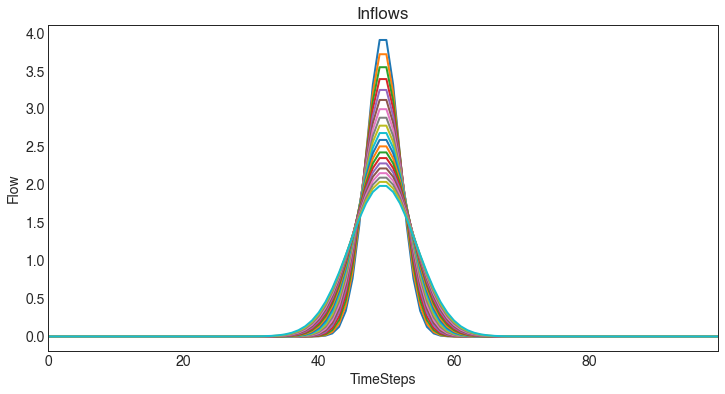

In [454]:
ax = inflows.plot(legend=False, title="Inflows")
ax.set_xlabel("TimeSteps")
ax.set_ylabel("Flow")

In [455]:
def single_basin(actions, flows):
    env = environment(baestorm.load_networks("parallel"), False)
    data = {}
    data["outflow"] = []
    data["overflow"] = []
    data["depth"] = []
    # pad inflows, so that the systems receds
    flows = np.append(flows, np.zeros(300))
    for time in range(0, len(flows)):
        # set the gate_position
        env._setValvePosition("1", actions)
        # set inflow
        env.sim._model.setNodeInflow("P1", 3 * flows[time])
        env.sim._model.setNodeInflow("P2", 0.0)
        # record_data
        data["outflow"].append(env._getLinkFlow("1"))
        data["overflow"].append(env.sim._model.getNodeResult("P1", 4))
        data["depth"].append(env._getNodeDepth("P1"))
        # step through simulation
        _ = env.step()
    env.terminate()
    return data["outflow"], sum(data["overflow"]), data["depth"]

In [456]:
data_flows = {}
for i in inflows.keys():
    flows, overflow, depth  = single_basin(1.0, inflows[i].values)
    data_flows[i] = flows
data_flows = pd.DataFrame.from_dict(data_flows)

Text(0, 0.5, 'Outflow')

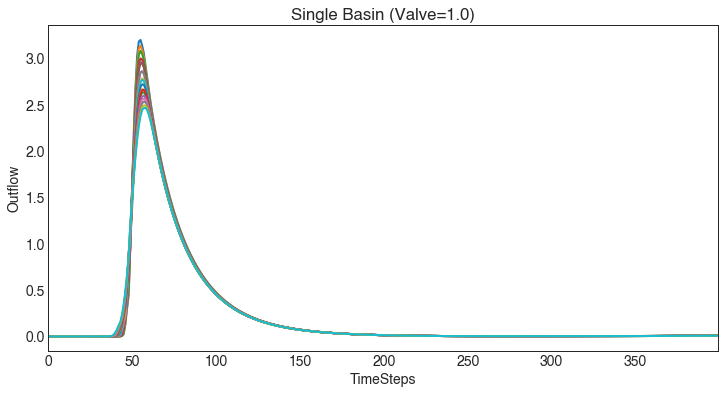

In [457]:
ax = data_flows.plot(legend=False, title="Single Basin (Valve=1.0)")
ax.set_xlabel("TimeSteps")
ax.set_ylabel("Outflow")

In [458]:
def objective_function(x):
    valves = x[0][0]
    # Sample a random inflow
    temp_1 = np.random.choice(np.linspace(0, 19, 20, dtype=int))
    # Simulate and generate flow transformations 
    flows, overflows, depth = single_basin(valves, inflows[str(temp_1)].values)
    # If completely closed, then penalize on depth
    threshold=1.0
    # IF flows exceed threhold, penalize based on the diviation
    flows = pd.Series(flows)
    overflows = pd.Series(overflows)
    
    # Total Inflow 
    sum_inflows = inflows[str(temp_1)].sum()
    sum_overflows = overflows.sum()

    # Flow below threshold
    flows[flows > threshold] = 0.0
    sum_flows_b_thres = flows.sum()
    
    reward = - np.exp(sum_flows_b_thres/(sum_inflows+10**(-5)) + sum_overflows/(sum_inflows+10**(-5)))
    
    #flows_sub = flows.sub(threshold)
    #flows_sub[flows_sub < 0.0] = 0.0
    #if flows.sum() == 0.0:
    #    flow_ration = 0.0
    #else:
    #    flow_ration = flows_sub.sum()/flows.sum()
    #reward = np.exp(overflows/inflows[str(temp_1)].sum() + flow_ration + depth[-1]/2.0) - 1.0
    # Maximize the flows below threshold 
    return reward

In [459]:
actions = np.linspace(0.0, 1.0, 30)
reward = np.zeros((20, 30))
for action in range(0, 30):
    for rainevent in range(0, 20):
        reward[rainevent, action] = objective_function(actions[action].reshape(-1,1))

Text(0.5, 1.0, 'Objective Function')

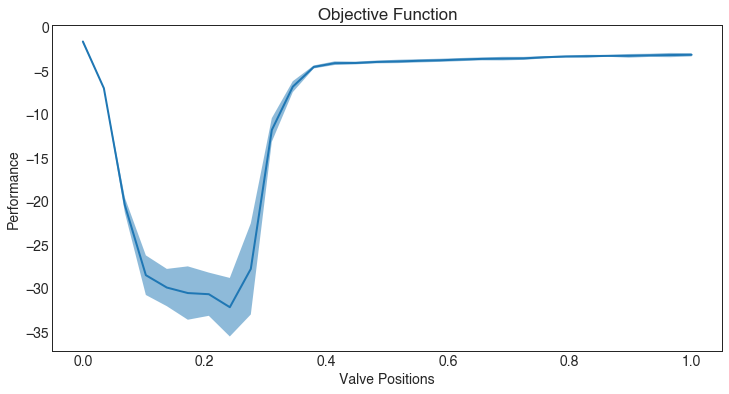

In [460]:
m = reward.mean(axis=0)
std = np.std(reward, 0)
up = m + 2.0 * std
dwn = m - 2.0 * std
plt.plot(actions, reward.mean(axis=0))
plt.fill_between(actions, up, dwn, alpha=0.5)
plt.xlabel("Valve Positions")
plt.ylabel("Performance")
plt.title("Objective Function")

In [461]:
x = []
y = []

for i in range(0, 200):
    x_t = np.array(np.random.choice(np.linspace(0.0, 1.0, 200))) # random action between 0 to 1
    y_t = objective_function(x_t.reshape(-1,1))
    x.append(x_t)
    y.append(y_t)

In [462]:
y_train = np.array(y)
x_train = np.array(x)

Text(0.5, 1.0, 'Normalized Data')

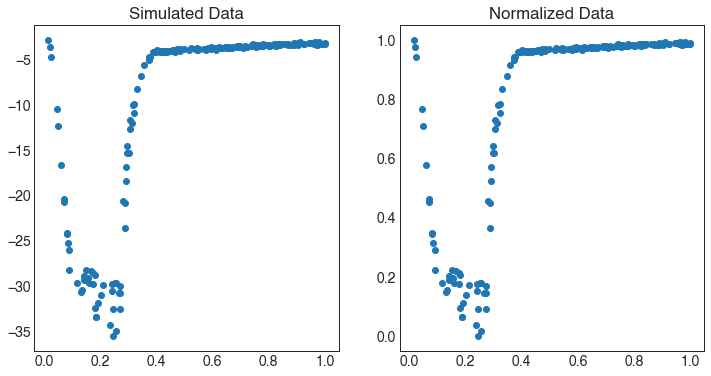

In [463]:
plt.rcParams["figure.figsize"] = (12,6)
plt.subplot(1,2,1)
plt.plot(x, y, 'o')
plt.title("Simulated Data")
plt.subplot(1,2,2)
y_train = (y - np.array(y).min())/(np.array(y).max() - np.array(y).min())
plt.plot(x_train, y_train, 'o')
plt.title("Normalized Data")

## Vanilla - Gaussian Processes 

VGP uses an uniform covariance. It is estimated by minimizing MLE.

In [464]:
kernel_vgp = GPy.kern.RBF(input_dim=1) + GPy.kern.White(input_dim=1)
vgp = GPy.models.GPRegression(x_train.reshape(-1,1), y_train.reshape(-1,1), kernel_vgp)
vgp.optimize(messages=False)
vgp.optimize_restarts(num_restarts = 10)

Optimization restart 1/10, f = -343.4466425825151
Optimization restart 2/10, f = -335.0242658025225
Optimization restart 3/10, f = -335.02426582547463
Optimization restart 4/10, f = -343.4466425875494
Optimization restart 5/10, f = -343.44664258562307
Optimization restart 6/10, f = -343.446642587571
Optimization restart 7/10, f = -343.4466425875752
Optimization restart 8/10, f = -343.44664258751015
Optimization restart 9/10, f = -335.02426582550254
Optimization restart 10/10, f = -343.44664258586874


Text(0.5, 1.0, 'Objective Function')

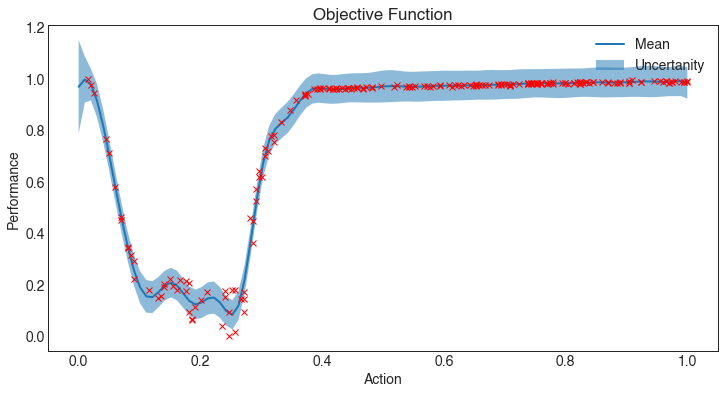

In [465]:
# Plot error bounds
x_test = np.linspace(0.0,1.0, 100)
vgp_m, v = vgp.predict(x_test.reshape(-1,1))
vgp_up = vgp_m.reshape(-1) + 2.0*np.sqrt(v.reshape(-1))
vgp_dwn = vgp_m.reshape(-1) - 2.0*np.sqrt(v.reshape(-1))

plt.fill_between(x_test, vgp_up, vgp_dwn, alpha=0.5, label="Uncertanity")
plt.plot(x_test, vgp_m, label="Mean")
plt.plot(x_train, y_train,'x',color='red')
plt.legend()
plt.ylabel("Performance")
plt.xlabel("Action")
plt.title("Objective Function")

## Hetroscadastic Gaussian Processes

In [466]:
# RBF and WhiteNoise kernel
kernel1 = GPy.kern.RBF(input_dim=1) + GPy.kern.White(input_dim=1)
gp1 = GPy.models.GPRegression(x_train.reshape(-1,1),y_train.reshape(-1,1),kernel1)
gp1.optimize(messages=False)
gp1.optimize_restarts(num_restarts = 5)

Optimization restart 1/5, f = -343.4466425825151
Optimization restart 2/5, f = -343.44664258755336
Optimization restart 3/5, f = -343.446642586793
Optimization restart 4/5, f = -343.4466425874717
Optimization restart 5/5, f = -343.446642586489


In [468]:
m, v = gp1.predict(x_train.reshape(-1,1))
s = 20
variance_noise = np.zeros(len(x_train))
for j in range(0, len(x)):
    var = 0.0
    for i in range(0, s):
        var += 0.5 * (y_train[j] - np.random.normal(m[j], v[j]))**2
    variance_noise[j] = var/s
z = np.log(variance_noise)

Text(0.5, 1.0, 'Noise Mean Estimate')

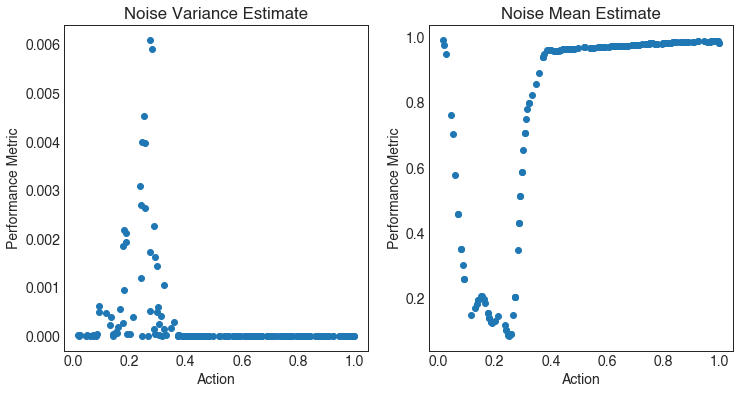

In [469]:
plt.subplot(1,2,1)
plt.plot(x, variance_noise,'o')
plt.xlabel("Action")
plt.ylabel("Performance Metric")
plt.title("Noise Variance Estimate")
plt.subplot(1,2,2)
plt.plot(x, m,'o')
plt.xlabel("Action")
plt.ylabel("Performance Metric")
plt.title("Noise Mean Estimate")

In [470]:
kernel2 = GPy.kern.RBF(input_dim=1) + GPy.kern.White(input_dim=1)
gp2 = GPy.models.GPRegression(x_train.reshape(-1,1),z.reshape(-1,1),kernel2)
gp2.optimize(messages=False)
gp2.optimize_restarts(num_restarts = 2)
m_n, v_n = gp2.predict(x_train.reshape(-1,1))

Optimization restart 1/2, f = 369.53321812768024
Optimization restart 2/2, f = 369.5332181276728


In [471]:
rbf = GPy.kern.RBF(input_dim=1)
noise = GPy.kern.WhiteHeteroscedastic(input_dim=1, num_data=x_train.shape[0])
k3 = rbf + noise
gp3 = GPy.models.GPRegression(x_train.reshape(-1,1), y_train.reshape(-1,1), k3)
k3.parts[1].variance = np.exp(m_n).reshape(x_train.shape[0])

In [472]:
k3.parts[0] = kernel1.parts[0]
gp3.optimize()
gp3.optimize_restarts(5)

Optimization restart 1/5, f = -738.8861755727467
Optimization restart 2/5, f = -720.8361655516519
Optimization restart 3/5, f = -736.4803106944149
Optimization restart 4/5, f = -730.0814373425384
Optimization restart 5/5, f = -735.5744868206428


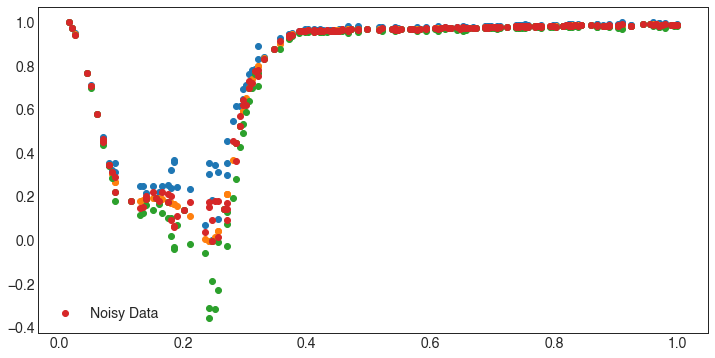

In [473]:
m, v = gp3.predict(x_train.reshape(-1,1))
up = m.reshape(-1) + 2.0*np.sqrt(v.reshape(-1))
dwn = m.reshape(-1) - 2.0*np.sqrt(v.reshape(-1))
plt.plot(x_train, up, 'o')
plt.plot(x_train, m, 'o')
plt.plot(x_train, dwn, 'o')
plt.plot(x_train, y_train, 'o', label="Noisy Data")
plt.legend()

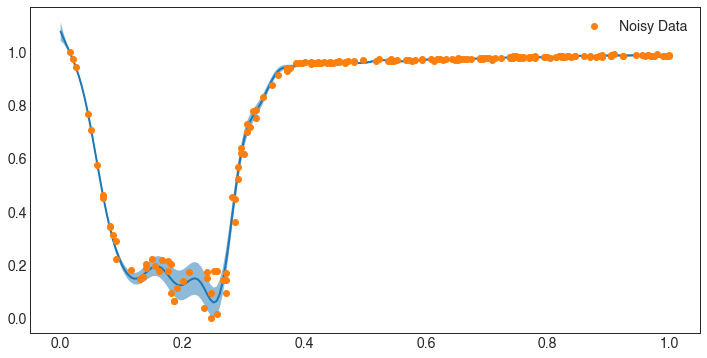

In [474]:
valve = np.linspace(0, 1.0, 200)
m_n, v_n = gp2.predict(valve.reshape(-1,1))
k3.parts[1].variance = np.exp(m_n).reshape(valve.shape[0])
m, v = gp3.predict(valve.reshape(-1,1))
up = m.reshape(-1) + 2.0*np.sqrt(v.reshape(-1))
dwn = m.reshape(-1) - 2.0*np.sqrt(v.reshape(-1))
plt.fill_between(valve, up, dwn, alpha=0.5)
plt.plot(valve, m)
plt.plot(x_train, y_train, 'o', label="Noisy Data")
plt.legend()

## Scale up

Text(0.5, 1.0, 'Objective Function')

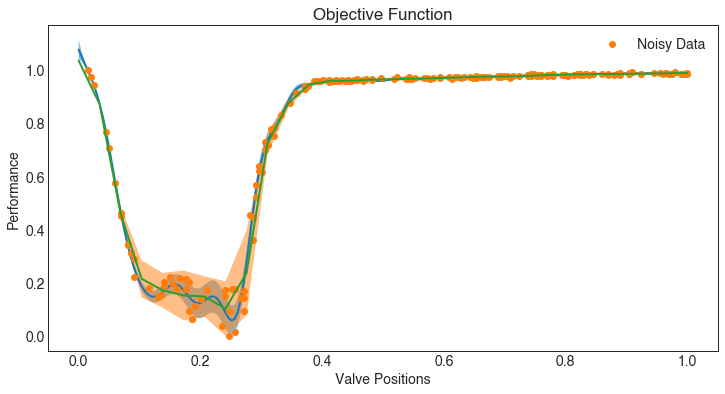

In [475]:
valve = np.linspace(0, 1.0, 200)
m_n, v_n = gp2.predict(valve.reshape(-1,1))
k3.parts[1].variance = np.exp(m_n).reshape(valve.shape[0])
m_t, v_t = gp3.predict(valve.reshape(-1,1))
up_t = m_t.reshape(-1) + 2.0*np.sqrt(v_t.reshape(-1))
dwn_t = m_t.reshape(-1) - 2.0*np.sqrt(v_t.reshape(-1))
plt.fill_between(valve, up_t, dwn_t, alpha=0.5)
plt.plot(valve, m_t)
plt.plot(x_train, y_train, 'o', label="Noisy Data")
plt.legend()


reward_t = (reward - np.array(y).min())/(np.array(y).max() - np.array(y).min())
m = reward_t.mean(axis=0)
std = np.std(reward_t, 0)
up = m + 2.0 * std
dwn = m - 2.0 * std
plt.plot(actions, reward_t.mean(axis=0))
plt.fill_between(actions, up, dwn, alpha=0.5)
plt.xlabel("Valve Positions")
plt.ylabel("Performance")
plt.title("Objective Function")

In [476]:
data_to_save = {
    "emp_x": actions,
    "emp_y_mean": reward.mean(axis=0),
    "emp_y_up":up,
    "emp_y_dwm":dwn,
    "vgp_x":x_test,
    "vgp_y_mean": vgp_m,
    "vgp_y_up":vgp_up,
    "vgp_y_dwm":vgp_dwn,
    "hgp_x":valve,
    "hgp_y_mean": m_t,
    "hgp_y_up":up_t,
    "hgp_y_dwm":dwn_t,
    "sample_x":x_train,
    "sample_y":y_train
}

In [477]:
np.save("./data_emp", data_to_save)